In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
# df['1_run_id'] = df['1_run_id'].astype('int64')
# df.sort_values(['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id'], inplace=True, ignore_index=True)

In [3]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,28
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,69
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,74
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,86
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,103
...,...,...,...,...,...
499531,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,19
499532,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,35
499533,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,83
499534,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,90


In [4]:
df.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [5]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

# Mean Runtime and CV Per Provider
- Q: Has a provider a overall characterstics or do specific regions stand out?
- Q: Does have one provider an overall more volatile region?

In [6]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)

AWS


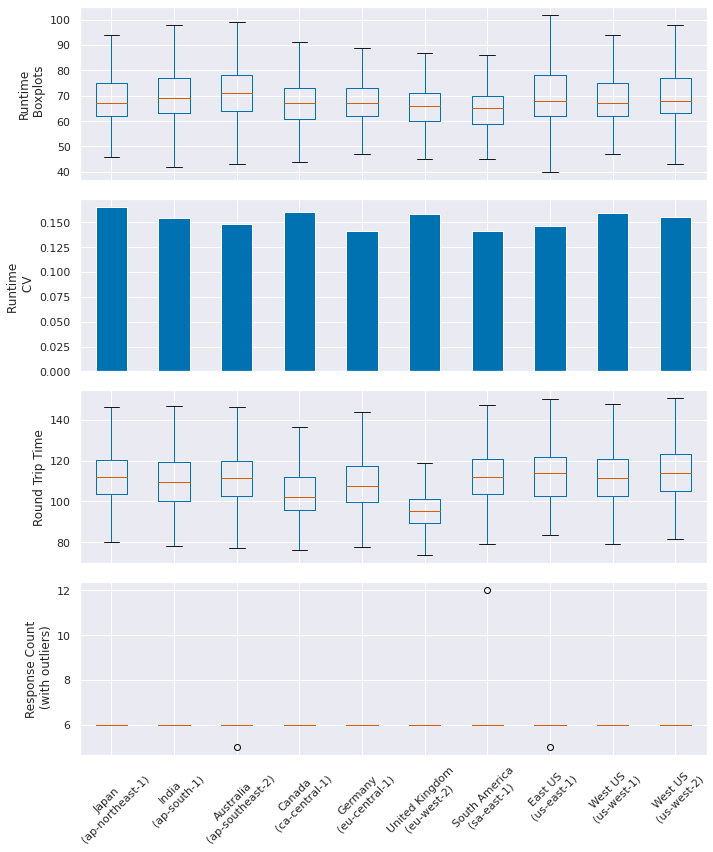

runtimebx 
                          runtime                                          \
                           count       mean        std   min   25%   50%   
provider region                                                            
AWS      ap-northeast-1  17370.0  69.449914  11.498890  33.0  62.0  67.0   
         ap-south-1      17364.0  70.704676  10.913137  42.0  63.0  69.0   
         ap-southeast-2  17375.0  71.127482  10.546134  40.0  64.0  71.0   
         ca-central-1    17382.0  68.036762  10.909589  40.0  61.0  67.0   
         eu-central-1    17370.0  68.289983   9.618368  35.0  62.0  67.0   
         eu-west-2       17358.0  67.141030  10.623037  39.0  60.0  66.0   
         sa-east-1       17364.0  65.866563   9.318072  36.0  59.0  65.0   
         us-east-1       17309.0  70.228840  10.279165  31.0  62.0  68.0   
         us-west-1       17358.0  69.494815  11.071164  47.0  62.0  67.0   
         us-west-2       17316.0  70.398706  10.962344  38.0  63.0  68.0   


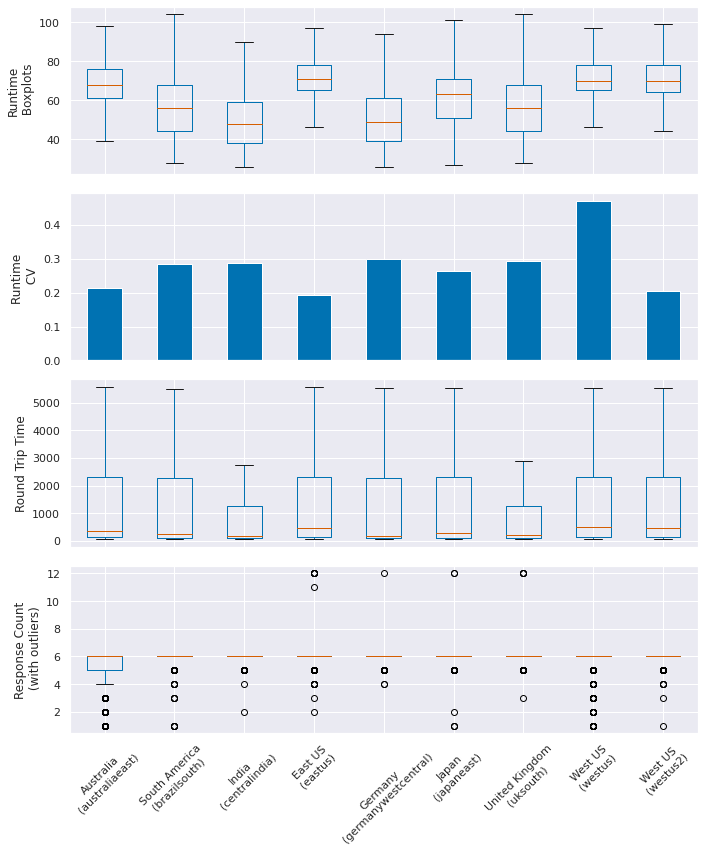

runtimebx 
                              runtime                                          \
                               count       mean        std   min   25%   50%   
provider region                                                                
AZURE    australiaeast       14768.0  69.747765  14.807410  39.0  61.0  68.0   
         brazilsouth         17152.0  57.161206  16.292097  28.0  44.0  56.0   
         centralindia        17298.0  49.828362  14.368943  26.0  38.0  48.0   
         eastus              17105.0  73.323414  14.246454  42.0  65.0  71.0   
         germanywestcentral  17309.0  51.202322  15.262342  26.0  39.0  49.0   
         japaneast           17294.0  61.974789  16.320018  27.0  51.0  63.0   
         uksouth             17303.0  57.489510  16.833038  28.0  44.0  56.0   
         westus              16504.0  72.765148  34.187493  44.0  65.0  70.0   
         westus2             17229.0  72.876197  14.937189  39.0  64.0  70.0   

                           

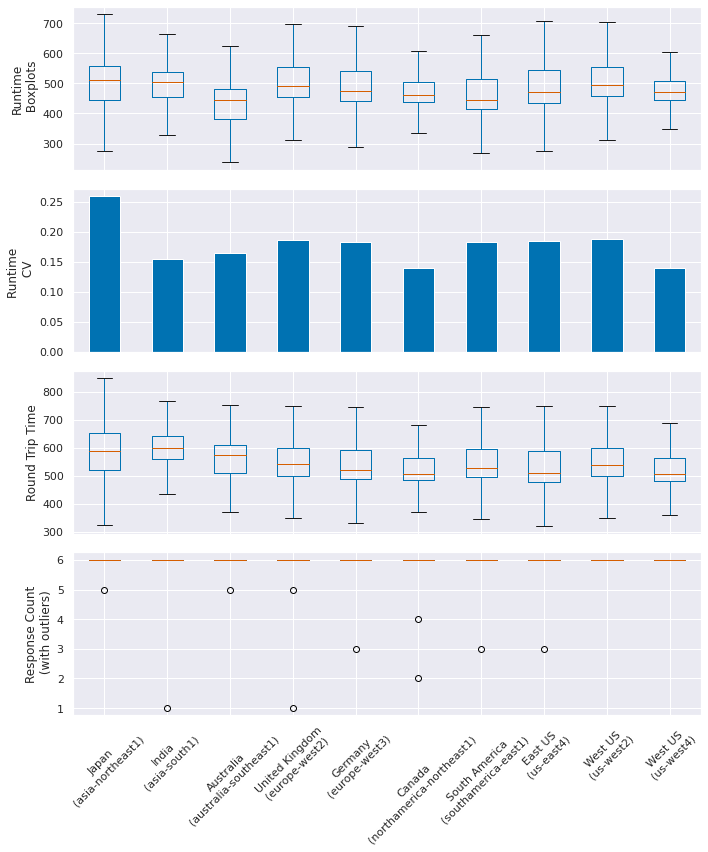

runtimebx 
                                   runtime                                 \
                                    count        mean         std    min   
provider region                                                            
GCP      asia-northeast1          17399.0  512.240703  132.788691  146.0   
         asia-south1              17401.0  504.527383   78.153693  171.0   
         australia-southeast1     17405.0  436.331456   71.910657  150.0   
         europe-west2             17400.0  498.717184   92.964757  153.0   
         europe-west3             17403.0  484.635120   88.416021  176.0   
         northamerica-northeast1  17400.0  465.446092   65.125431  152.0   
         southamerica-east1       17397.0  456.039949   83.640062  130.0   
         us-east4                 17403.0  485.229845   89.532139  190.0   
         us-west2                 17400.0  499.634598   94.265091  134.0   
         us-west4                 17400.0  472.868161   66.074685  175.0   


In [7]:
for provider in df['provider'].unique():
    SHAREX = True
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    bxdf = df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['provider','region'], observed=True)
    utils.boxplot(axes[0], bxdf, "Runtime\n Boxplots", lambda x: x, rot=90, sharex=SHAREX)
    
    # COV
    cov_provider = cov_df.loc[provider]
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    axes[1].set_ylabel('Runtime \n CV')
    
    # Round Trip Time
    rtt_df = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider].groupby(['region'], observed=True)
    utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX)
       
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_boxplot = resp_df[['provider', 'region', 'counts']].groupby(['provider', 'region'], observed=True)
    ax = utils.boxplot(axes[3], df_boxplot, 'Response Count\n (with outliers)', lambda x: x, rot=45, sharex=False, showfliers=True)
    
    # Set Region Names
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    # region_name_ax.get_legend().remove()
    region_name_ax.set_xticklabels(labels)
    region_name_ax.set_xlabel('')

    fig.tight_layout()

    print(provider)
    utils.plot( ['region_analysis', f'overview_{provider}'], runtimebx=bxdf.describe(), rttbx=rtt_df.describe(), respbx=resp_df.describe(), cov=cov_provider)

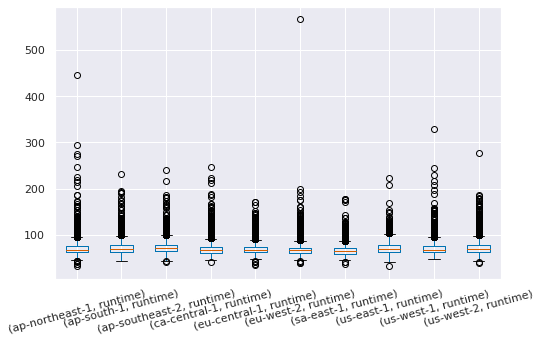

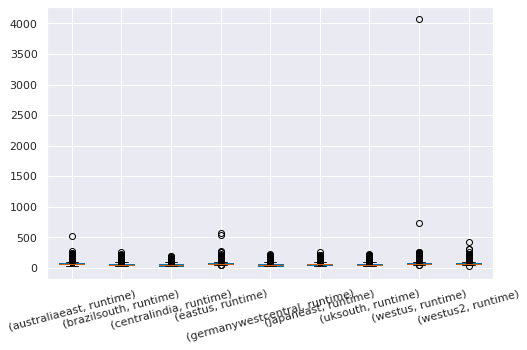

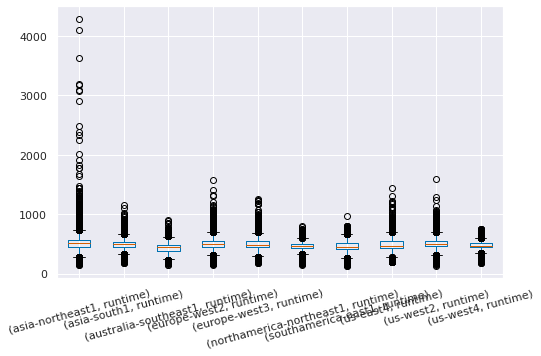

In [8]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
# Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(15)
    plt.show()
    plt.close()

# CPU Types Analysis
Different Types of CPUs for the different regions.

In [9]:
unique_cpu_types_df = df.groupby(['provider', 'region', 'cpuType'], observed=True)['cpuType'].count() #.agg({'cpuType':'count'})
unique_cpu_types_df = pd.DataFrame(unique_cpu_types_df).groupby(['provider', 'region'], group_keys=False).apply(lambda df: (df['cpuType'] / df['cpuType'].sum()) * 100)
unique_cpu_types_percentage_df = pd.DataFrame(unique_cpu_types_df)
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.rename(columns={'cpuType': 'Percentage'})
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.reset_index('cpuType')
unique_cpu_types_pivoted_df = unique_cpu_types_percentage_df.pivot(columns=['cpuType'])

In [10]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon @ 2.50GHz - Model 63",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Xeon Platinum 8171M CPU @ 2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Xeon CPU E5-2673 v4 @ 2.30GHz - Model 79",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Xeon Platinum 8272CL CPU @ 2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Xeon CPU E5-2673 v3 @ 2.40GHz - Model 63",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Xeon @ 3.00GHz - Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79",
    "unknown - Model 63": "Model 63"
}

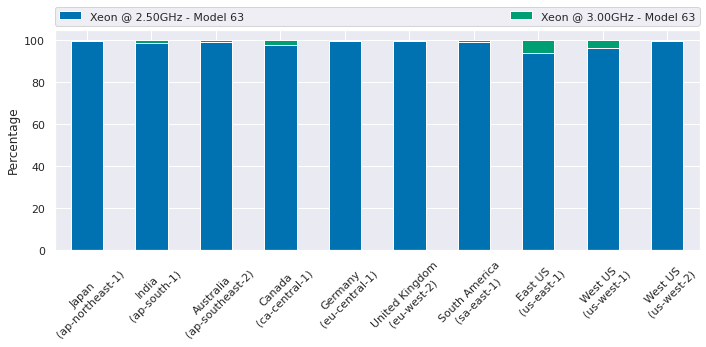

cpu_types_percentrage 
                 Xeon @ 2.50GHz - Model 63  Xeon @ 3.00GHz - Model 63
region                                                              
ap-northeast-1                  99.539436                   0.460564
ap-south-1                      98.658143                   1.341857
ap-southeast-2                  99.021583                   0.978417
ca-central-1                    97.670003                   2.329997
eu-central-1                    99.712147                   0.287853
eu-west-2                       99.953912                   0.046088
sa-east-1                       99.343469                   0.656531
us-east-1                       94.003120                   5.996880
us-west-1                       96.549142                   3.450858
us-west-2                       99.965350                   0.034650


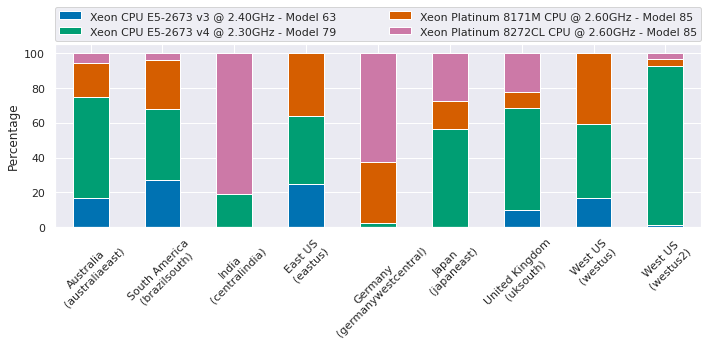

cpu_types_percentrage 
                     Xeon CPU E5-2673 v3 @ 2.40GHz - Model 63  \
region                                                         
australiaeast                                      16.847237   
brazilsouth                                        26.970616   
centralindia                                        0.323737   
eastus                                             24.811459   
germanywestcentral                                       NaN   
japaneast                                           0.057824   
uksouth                                            10.160088   
westus                                             16.741396   
westus2                                             1.160833   

                    Xeon CPU E5-2673 v4 @ 2.30GHz - Model 79  \
region                                                         
australiaeast                                      57.868364   
brazilsouth                                        40.689132   
centralindia   

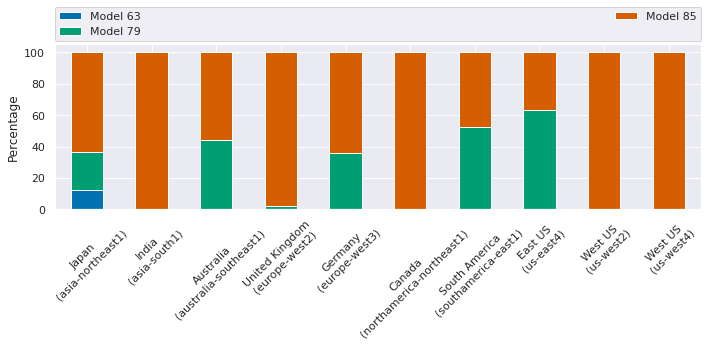

cpu_types_percentrage 
                           Model 63   Model 79    Model 85
region                                                   
asia-northeast1          12.207598  24.622105   63.170297
asia-south1                    NaN        NaN  100.000000
australia-southeast1           NaN  44.096524   55.903476
europe-west2                   NaN   2.091954   97.908046
europe-west3                   NaN  36.057002   63.942998
northamerica-northeast1        NaN        NaN  100.000000
southamerica-east1             NaN  52.296373   47.703627
us-east4                       NaN  63.603976   36.396024
us-west2                       NaN        NaN  100.000000
us-west4                       NaN        NaN  100.000000


In [11]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(10,5))
    subdf = unique_cpu_types_pivoted_df

    providerdf = subdf.loc[provider]

    cols = providerdf.columns.droplevel(0)
    new_cols = [cpu_map[x] for x in cols]
    providerdf.columns = new_cols
    providerdf = providerdf.dropna(axis=1, how='all')
    
    providerdf.plot.bar(stacked=True, ax=axes, rot=45)

    axes.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
    axes.set_xlabel('')
    axes.set_ylabel('Percentage')
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'cpu_types_{provider}'], cpu_types_percentrage=providerdf)

In [12]:
cputype_per_invocation_df = pd.DataFrame(df.groupby(['provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().rename('Count'))

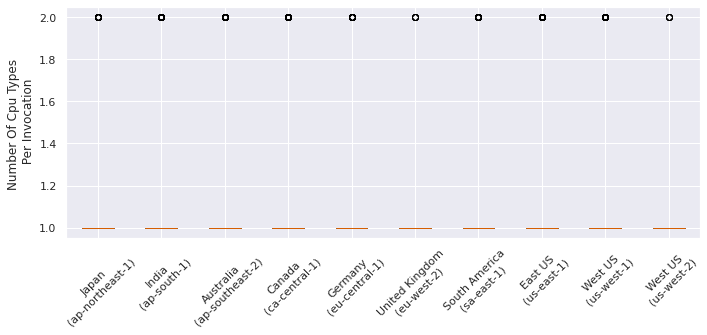

cputype_per_invocation_df 
                  Count                                             
                 count      mean       std  min  25%  50%  75%  max
region                                                             
ap-northeast-1  2895.0  1.013126  0.113834  1.0  1.0  1.0  1.0  2.0
ap-south-1      2894.0  1.038701  0.192914  1.0  1.0  1.0  1.0  2.0
ap-southeast-2  2896.0  1.027970  0.164914  1.0  1.0  1.0  1.0  2.0
ca-central-1    2897.0  1.066275  0.248806  1.0  1.0  1.0  1.0  2.0
eu-central-1    2895.0  1.008636  0.092542  1.0  1.0  1.0  1.0  2.0
eu-west-2       2893.0  1.001728  0.041544  1.0  1.0  1.0  1.0  2.0
sa-east-1       2893.0  1.018666  0.135365  1.0  1.0  1.0  1.0  2.0
us-east-1       2885.0  1.134835  0.341607  1.0  1.0  1.0  1.0  2.0
us-west-1       2893.0  1.081922  0.274293  1.0  1.0  1.0  1.0  2.0
us-west-2       2886.0  1.001386  0.037210  1.0  1.0  1.0  1.0  2.0


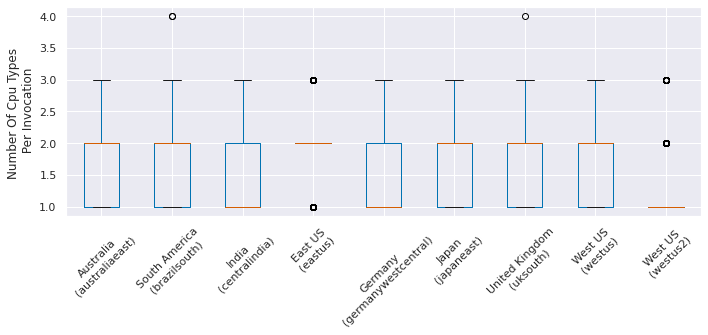

cputype_per_invocation_df 
                      Count                                             
                     count      mean       std  min  25%  50%  75%  max
region                                                                 
australiaeast       2875.0  1.661565  0.608940  1.0  1.0  2.0  2.0  3.0
brazilsouth         2878.0  1.773454  0.614474  1.0  1.0  2.0  2.0  4.0
centralindia        2895.0  1.338515  0.476923  1.0  1.0  1.0  2.0  3.0
eastus              2871.0  1.935563  0.588827  1.0  2.0  2.0  2.0  3.0
germanywestcentral  2897.0  1.489472  0.516285  1.0  1.0  1.0  2.0  3.0
japaneast           2894.0  1.747754  0.595484  1.0  1.0  2.0  2.0  3.0
uksouth             2893.0  1.751469  0.608920  1.0  1.0  2.0  2.0  4.0
westus              2836.0  1.820522  0.594402  1.0  1.0  2.0  2.0  3.0
westus2             2896.0  1.194061  0.424198  1.0  1.0  1.0  1.0  3.0


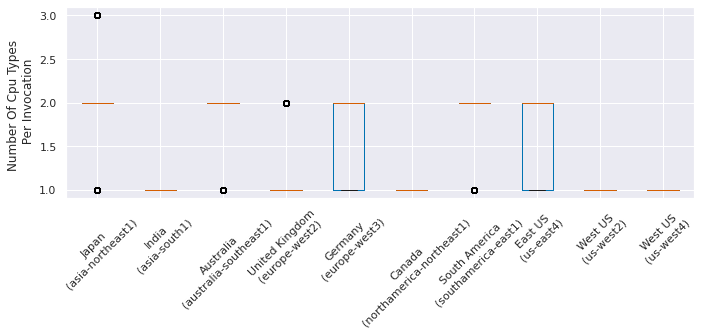

cputype_per_invocation_df 
                           Count                                             
                          count      mean       std  min  25%  50%  75%  max
region                                                                      
asia-northeast1          2900.0  1.953793  0.625934  1.0  2.0  2.0  2.0  3.0
asia-south1              2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
australia-southeast1     2901.0  1.802827  0.397933  1.0  2.0  2.0  2.0  2.0
europe-west2             2901.0  1.084454  0.278115  1.0  1.0  1.0  1.0  2.0
europe-west3             2901.0  1.685281  0.464484  1.0  1.0  2.0  2.0  2.0
northamerica-northeast1  2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
southamerica-east1       2900.0  1.860000  0.347047  1.0  2.0  2.0  2.0  2.0
us-east4                 2901.0  1.635643  0.481332  1.0  1.0  2.0  2.0  2.0
us-west2                 2900.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
us-west4                 2900.0  1.000000  0.000

In [13]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(10,5))
    subdf = cputype_per_invocation_df
    provdf = subdf.loc[provider]
    provdf.boxplot(by='region', rot=45, ax=axes)
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    # Other Formatting
    axes.set_title('')
    fig.suptitle('')
    axes.set_xlabel('')
    axes.set_ylabel('Number Of Cpu Types \n Per Invocation')
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())